In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import polars as pl

env = "local"

In [2]:
if env == "local":
    os.chdir("/Users/samuel/Documents/GitHub/QB-GPT/")
else:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/MyDrive/NFL_Challenge/NFL-GPT/NFL data")

In [3]:
os.listdir()

['data_models',
 '.DS_Store',
 'app',
 'LICENSE',
 'models',
 'README.md',
 '.gitignore',
 '.gitattributes',
 'indexv2',
 'data_preprocessing',
 'index',
 '.git',
 'notebooks']

In [4]:
training_data = tf.data.Dataset.load("data_models/Helenos/encoded_train_tiny")
testing_data = tf.data.Dataset.load("data_models/Helenos/encoded_test_tiny")

In [5]:
train_encodings = list(training_data)

sub_vectors_data = [{"vector" if k == "sub_vector" else k:v.numpy() for k,v in d.items()} for d in train_encodings]
sub_vectors_data = [{k:v for k,v in d.items() if k != "concatenated_vector"} for d in sub_vectors_data]

conc_vectors_data = [{"vector" if k == "concatenated_vector" else k:v.numpy() for k,v in d.items()} for d in train_encodings]
conc_vectors_data = [{k:v for k,v in d.items() if k != "sub_vector"} for d in conc_vectors_data]

In [6]:
len(sub_vectors_data)

144074

In [7]:
test_encodings = list(testing_data)

query_vectors = [{k:v.numpy() for k,v in d.items()} for d in test_encodings]

In [8]:
import lancedb
db = lancedb.connect("data_models/Helenos/lance_helenos")

In [9]:
sub_tbl = db.create_table("subtracted_vectors", sub_vectors_data, mode="overwrite")
conc_tbl = db.create_table("concatenated_vectors", conc_vectors_data, mode="overwrite")

[2023-11-06T13:40:24Z WARN  lance::dataset] No existing dataset at /Users/samuel/Documents/GitHub/QB-GPT/data_models/Helenos/lance_helenos/subtracted_vectors.lance, it will be created
[2023-11-06T13:40:25Z WARN  lance::dataset] No existing dataset at /Users/samuel/Documents/GitHub/QB-GPT/data_models/Helenos/lance_helenos/concatenated_vectors.lance, it will be created


In [10]:
def get_neighbors(query,
                  table,
                  n_select,
                  metric, 
                  playtype):
    res = (table.
           search(query).
           where(f"""
                  playtype == {playtype}
                  """).
           metric(metric).
           limit(n_select).
           to_pandas())
    
    res = res[[c for c in res.columns if c not in ["id", "vector"]]].drop_duplicates().reset_index(drop = True)
    return res

In [11]:
test_l2 = get_neighbors(query_vectors[456]["sub_vector"], sub_tbl, 4000, "l2", query_vectors[0]["playtype"])
test_cos = get_neighbors(query_vectors[456]["sub_vector"], sub_tbl, 4000, "cosine", query_vectors[0]["playtype"])

In [12]:
test_cos.shape

(2406, 6)

<Axes: xlabel='index', ylabel='_distance'>

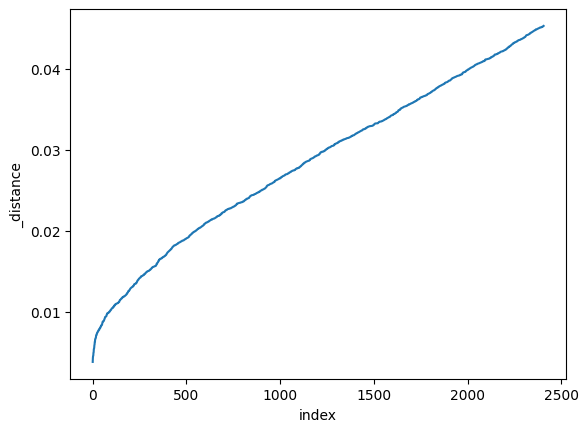

In [13]:
import seaborn as sns

sns.lineplot(test_cos.reset_index(), x = "index", y="_distance")

<Axes: xlabel='index', ylabel='_distance'>

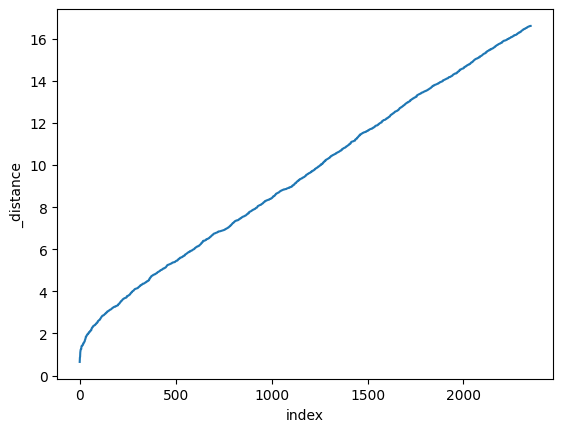

In [14]:
sns.lineplot(test_l2.reset_index(), x = "index", y="_distance")

In [15]:
from scipy.stats import exponnorm

def compute_mean(df, var):
    return np.mean(df[var])

def compute_median(df, var):
    return np.median(df[var])

def compute_std(df, var):
    return np.std(df[var])

def compute_weighted_mean(df, var):
    return sum((1/df["_distance"]) * df[var])/sum(1/df["_distance"])

def get_exponnorm(df, var):
    parameters = exponnorm.fit(df[var])
    return {"a" : parameters[0],
            "mean" : parameters[1],
            "scale" : parameters[2]}
    
def process_df(df, cutoff, n_select, metric, true_yard, true_success, procedure):
    spe = df.copy()
    if n_select is not None:
        spe = spe.head(n_select)
        
    if cutoff is not None:
        spe.loc[spe['yards'] > cutoff, 'yards'] = cutoff
        
    parameters = get_exponnorm(spe, "yards")
    
    return {"Procedure": procedure,
            "PlayType" : np.unique(spe["playtype"])[0],
            "Metric" : metric, 
            "Cutoff" : cutoff,
            "n_selected" : n_select,
            "True_Yards" : true_yard,
            "True_success" : true_success,
            "Avg_yards" : compute_mean(spe, "yards"),
            "Weighted_Avg_yards" : compute_weighted_mean(spe, "yards"),
            "Median_yards" : compute_median(spe, "yards"),
            "Std_yards" : compute_std(spe, "yards"),
            "Avg_success" : compute_mean(spe, "Success"),
            "Weighted_Avg_success" : compute_mean(spe, "Success"),
            "Mean" : parameters["mean"],
            "Scale" : parameters["scale"],
            "Rate" : parameters["a"]}

def compile_l_of_d(list_of_d):
    merged_dict = {k : [] for k in list_of_d[0].keys()}
    for d in list_of_d:
        for key, value in d.items():
            merged_dict[key] += [value]
    merged_dict = {k: np.array(v) for k,v in merged_dict.items()}
    return merged_dict

def process_query(query, metric, table, n_selects, cutoffs, playtype, true_yards, true_success, procedure):
    n = 2000
    results = []
    
    res = get_neighbors(query, table, n, metric, playtype)
    
    for to_select in n_selects:
        for cutoff in cutoffs:
            processed = process_df(res, cutoff, to_select, metric, true_yards, true_success, procedure)
            results.append(processed)
    return compile_l_of_d(results)

In [17]:
from concurrent.futures import ThreadPoolExecutor
import concurrent
from tqdm import tqdm

# Define a function that processes a batch
def process_batch_with_progress(query):
    cos_sub = process_query(query=query["sub_vector"], 
                            metric="cosine", 
                            table=sub_tbl, 
                            n_selects=[5, 10, 300, 400, 500, 600], 
                            cutoffs= [10, 15, 20], 
                            playtype = query["playtype"], 
                            true_yards= query["yards"], 
                            true_success=query["Success"], 
                            procedure="Subtracted")
    
    cos_conc = process_query(query=query["concatenated_vector"], 
                            metric="cosine", 
                            table=conc_tbl, 
                            n_selects=[5, 10, 300, 400, 500, 600], 
                            cutoffs= [10, 15, 20], 
                            playtype = query["playtype"], 
                            true_yards= query["yards"], 
                            true_success=query["Success"], 
                            procedure="Concatenated")
    
    l2_sub = process_query(query=query["sub_vector"], 
                            metric="L2", 
                            table=sub_tbl, 
                            n_selects=[5, 10, 300, 400, 500, 600], 
                            cutoffs= [10, 15, 20], 
                            playtype = query["playtype"], 
                            true_yards= query["yards"], 
                            true_success=query["Success"], 
                            procedure="Subtracted")
    
    l2_conc =process_query(query=query["concatenated_vector"], 
                            metric="L2", 
                            table=conc_tbl, 
                            n_selects=[5, 10, 300, 400, 500, 600], 
                            cutoffs= [10, 15, 20], 
                            playtype = query["playtype"], 
                            true_yards= query["yards"], 
                            true_success=query["Success"], 
                            procedure="Concatenated")
    
    pbar.update(1)  # Update the progress bar for each completed batch
    return [cos_sub, cos_conc, l2_sub, l2_conc]

In [19]:
import random
random.shuffle(query_vectors)

test = query_vectors[:1000]

res = []

with tqdm(total=len(test)) as pbar:
  for query in test:
    res.append(process_batch_with_progress(query))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


In [20]:
results = pd.concat([pd.concat([pd.DataFrame(s) for s in d]) for d in res]).reset_index(drop = True)

In [28]:
results.to_json("models/modeling/Helenos/results_knn.json")

In [21]:
test = results[(results["Procedure"] == "Concatenated") & (results["PlayType"] == 4) & (results["Metric"] == "L2") & (results["Cutoff"] == 20) & (results["n_selected"] == 400) & (results["True_Yards"] != 0)]

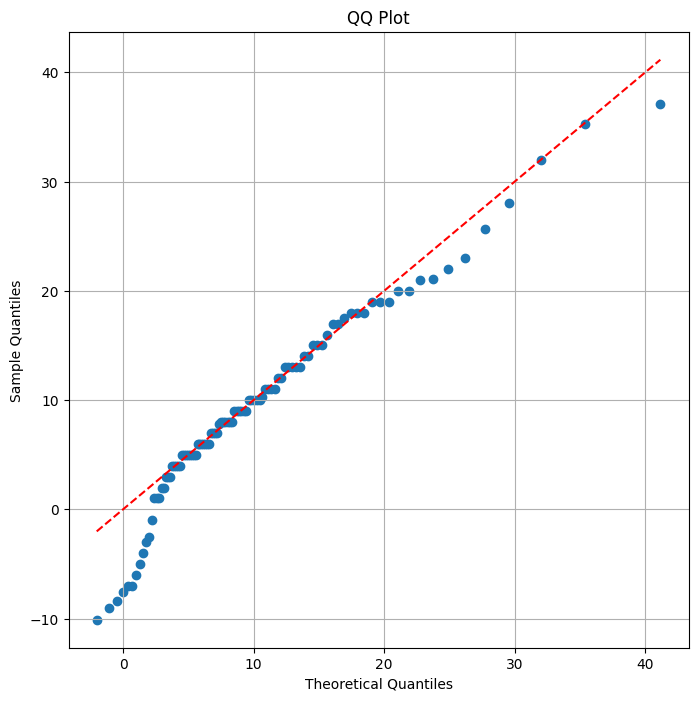

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

theoretical_quantiles = stats.exponnorm.ppf(np.linspace(0.01, 0.99, 100), 3, 2, 2.8)
inputt = np.array(test["True_Yards"])
inputt.sort()

sample_quantiles = np.percentile(inputt, np.linspace(1, 99, 100))

plt.figure(figsize=(8, 8))
plt.scatter(theoretical_quantiles, sample_quantiles)
plt.plot([theoretical_quantiles.min(), theoretical_quantiles.max()], [theoretical_quantiles.min(), theoretical_quantiles.max()], color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot')
plt.grid(True)
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score

def calculate_auc(data, var):
    y_true = data['True_success']
    y_pred = data[var]
    auc = roc_auc_score(y_true, y_pred)
    return auc

from sklearn.metrics import accuracy_score

def calculate_accuracy(data, var):
    y_true = data['True_success']
    y_pred = round(data[var])
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

import numpy as np

def calculate_rmse(data, var):
    spe_data = data[data["True_success"] == 1].reset_index(drop = True)
    y_true = spe_data['True_yard']
    y_pred = spe_data[var]
    rmse = np.sqrt(((y_pred - y_true) ** 2).mean())
    return rmse

def calculate_rmse_trunc(data, var, trunc):
    spe_data = data[data["True_success"] == 1].reset_index(drop = True)
    spe_data = spe_data[spe_data["True_yard"] < trunc].reset_index(drop = True)
    y_true = spe_data['True_yard']
    y_pred = spe_data[var]
    rmse = np.sqrt(((y_pred - y_true) ** 2).mean())
    return rmse

def eval_df(df, n_neighboors, var):
    spec_df = df[df["N_neighboors"] == n_neighboors].reset_index(drop = True)
    
    weight_rmse = calculate_rmse(spec_df, "Pred_yard_weighted")
    mean_rmse = calculate_rmse(spec_df, "Pred_yard_mean")
    
    trunc_50_weight_rmse = calculate_rmse_trunc(spec_df, "Pred_yard_weighted", 51)
    trunc_50_mean_rmse = calculate_rmse_trunc(spec_df, "Pred_yard_mean", 51)
    
    trunc_30_weight_rmse = calculate_rmse_trunc(spec_df, "Pred_yard_weighted", 31)
    trunc_30_mean_rmse = calculate_rmse_trunc(spec_df, "Pred_yard_mean", 31)
    
    weight_acc = calculate_accuracy(spec_df, "Pred_success_weighted")
    mean_acc = calculate_accuracy(spec_df, "Pred_success_mean")
    
    weight_auc = calculate_auc(spec_df, "Pred_success_weighted")
    mean_auc = calculate_auc(spec_df, "Pred_success_mean")
    
    return {"Procedure" : var,
            "N_neighboor" : n_neighboors,
            "weight_rmse" : weight_rmse,
            "mean_rmse" : mean_rmse,
            "trunc_50_weight_rmse" : trunc_50_weight_rmse,
            "trunc_50_mean_rmse" : trunc_50_mean_rmse,
            "trunc_30_weight_rmse" : trunc_30_weight_rmse,
            "trunc_30_mean_rmse" : trunc_30_mean_rmse,
            "weight_acc" : weight_acc,
            "mean_acc" : mean_acc,
            "weight_auc" : weight_auc,
            "mean_auc" : mean_auc}
    
from tqdm import tqdm

def compile_seq(list_of_trajs):
    merged_dict = {k : [] for k in list_of_trajs[0].keys()}

    with tqdm(total=len(list_of_trajs)) as pbar:
      for d in list_of_trajs:
        for key, value in d.items():
          merged_dict[key] += [value]
        pbar.update(1)
        
    merged_dict = {k: np.array(v) for k,v in merged_dict.items()}
    return merged_dict

In [24]:
from scipy.stats import exponnorm, norm

def one_hot(arr, length):
    b = np.zeros((arr.size, length))
    b[np.arange(arr.size), arr] = 1
    return b

def generate_preds(mean, scale, start, end):
    return [norm.cdf(n+0.5, mean, scale)-norm.cdf(n-0.5, mean, scale) for n in range(start, end+1, 1)]

def get_pred_proba(params, start, end):
    preds = np.array([generate_preds(param[0], param[1], start, end) for param in params])
    return preds

In [29]:
size = 300

In [30]:
test = results[(results["Procedure"] == "Subtracted") & (results["PlayType"] == 4) & (results["Metric"] == "cosine") & (results["Cutoff"] == 20) & (results["n_selected"] == size)]
test = test[test["True_Yards"] != 0]
test.loc[test['True_Yards'] > 20, 'True_Yards'] = 20

In [31]:
test

,Procedure,PlayType,Metric,Cutoff,n_selected,True_Yards,True_success,Avg_yards,Weighted_Avg_yards,Median_yards,Std_yards,Avg_success,Weighted_Avg_success,Mean,Scale,Rate
8,Subtracted,4,cosine,20,300,18,1,5.650000,5.585249,4.0,6.970473,0.643333,0.643333,-1.484356,3.016143,2.365407
80,Subtracted,4,cosine,20,300,10,1,4.810000,4.872191,2.5,7.683352,0.640000,0.640000,-1.861222,4.543051,1.468441
440,Subtracted,4,cosine,20,300,8,1,5.516667,NaN,4.0,7.004978,0.690000,0.690000,0.190006,4.920084,1.082637
584,Subtracted,4,cosine,20,300,8,1,5.763333,5.601882,5.0,8.002957,0.680000,0.680000,3.379618,7.643133,0.311876
656,Subtracted,4,cosine,20,300,20,1,6.386667,6.124257,6.0,7.764266,0.693333,0.693333,3.825913,7.336365,0.349047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71360,Subtracted,4,cosine,20,300,3,1,5.463333,5.569766,3.5,7.231090,0.663333,0.663333,-1.878926,3.062141,2.397747
71504,Subtracted,4,cosine,20,300,9,1,5.970000,6.236299,5.0,7.136930,0.700000,0.700000,-0.538417,4.001575,1.626467
71720,Subtracted,4,cosine,20,300,5,1,5.343333,4.922769,4.0,7.298775,0.666667,0.666667,-1.011780,4.359204,1.457854
71792,Subtracted,4,cosine,20,300,20,1,5.516667,16.791320,4.0,7.921051,0.643333,0.643333,-1.730953,4.422972,1.638629


In [32]:
Y_pred = get_pred_proba(test[["Avg_yards", "Std_yards"]].values, -99, 99)
Y_pred.shape

(391, 199)

In [33]:
check = np.array([v[0] if np.isnan(v[0]) == False else v[1] for v in test[["Weighted_Avg_yards", "Avg_yards"]].values])

In [34]:
Y_pred = one_hot(check.round().astype("int32"), 199)

In [35]:
Y_true = one_hot(np.array(test["True_Yards"]), 199)

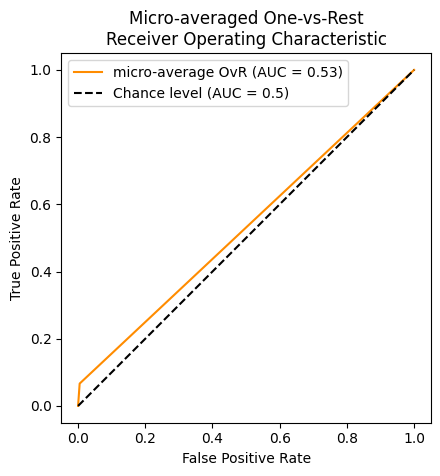

In [36]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    Y_true.ravel(),
    Y_pred.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

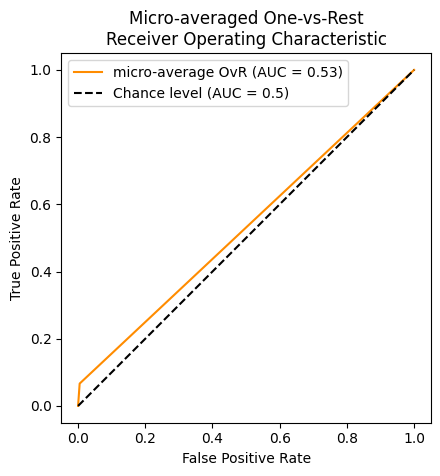

In [37]:
RocCurveDisplay.from_predictions(
    Y_true.ravel(),
    Y_pred.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [38]:
def CRPS(predicted_cdf, actual_yardage):
    N = len(predicted_cdf)
    C = 0

    with tqdm(total=len(range(N))) as pbar:
        for m in range(N):
            for n in range(-99, 99, 1):
                P_y_leq_n = exponnorm.cdf(n+0.5, predicted_cdf[m][2], predicted_cdf[m][0], predicted_cdf[m][1])  # Adjust the index to match the range
                H_n_minus_Y_m = 1 if (n - actual_yardage[m]) >= 0 else 0
                C += (P_y_leq_n - H_n_minus_Y_m) ** 2
            pbar.update(1)

    final_C = C/(199*N)
    return final_C

In [39]:
sizes = [5, 10, 300, 400, 500, 600]
procedures = ["Subtracted", "Concatenated"]
playtypes = [4, 7]
metrics = ["cosine", "L2"]
cutoffs = [10, 15, 20]

In [40]:
for size in [5, 10, 300, 400, 500, 600]:
    print(size)
    test = results[(results["Procedure"] == "Subtracted") & (results["PlayType"] == 4) & (results["Metric"] == "cosine") & (results["Cutoff"] == 20) & (results["n_selected"] == size)]
    
    auc = calculate_auc(test, "Weighted_Avg_success")
    print(auc)

5
0.498727288154083
10
0.5209815638598321
300
0.5179997818208265
400
0.5156179925091817
500
0.5107392637664998
600
0.5139634671094896


In [41]:
for size in [5, 10, 300, 400, 500, 600]:
    print(size)
    test = results[(results["Procedure"] == "Subtracted") & (results["PlayType"] == 4) & (results["Metric"] == "cosine") & (results["Cutoff"] == 20) & (results["n_selected"] == size)]
    test = test[test["True_Yards"] != 0]
    test.loc[test['True_Yards'] > 20, 'True_Yards'] = 20
    
    crps = CRPS(test[["Mean", "Scale", "Rate"]].values, np.array(test["True_Yards"]))
    print(crps)

5


100%|██████████| 391/391 [00:02<00:00, 144.51it/s]


0.029997326691881637
10


100%|██████████| 391/391 [00:02<00:00, 145.85it/s]


0.0280411448874645
300


100%|██████████| 391/391 [00:02<00:00, 145.77it/s]


0.0256057896987916
400


100%|██████████| 391/391 [00:02<00:00, 145.89it/s]


0.025564467542901172
500


100%|██████████| 391/391 [00:02<00:00, 146.47it/s]


0.025640953259951697
600


100%|██████████| 391/391 [00:02<00:00, 145.66it/s]

0.02560735370755223


In [42]:
bench = CRPS(np.array([[3,2,2.8] for e in test["True_Yards"]]), np.array(test["True_Yards"]))
print(bench)

100%|██████████| 391/391 [00:02<00:00, 145.03it/s]

0.023438028710742725


In [127]:
for size in [10, 30, 50, 100, 200, 300, 400, 500, 600]:
    print(size)
    test = results[(results["Procedure"] == "Subtracted") & (results["PlayType"] == 7) & (results["Metric"] == "cosine") & (results["Cutoff"] == 20) & (results["n_selected"] == size)]
    
    crps = CRPS(test[["Mean", "Scale", "Rate"]].values, np.array(test["True_Yards"]))
    print(crps)
    
bench = CRPS(np.array([[0, 2, 2] for e in test["True_Yards"]]), np.array(test["True_Yards"]))
print(bench)

10


100%|██████████| 417/417 [00:02<00:00, 144.91it/s]


0.015167899470353331
30


100%|██████████| 417/417 [00:02<00:00, 146.39it/s]


0.014774225311000443
50


100%|██████████| 417/417 [00:02<00:00, 145.93it/s]


0.014753557258544126
100


100%|██████████| 417/417 [00:02<00:00, 147.05it/s]


0.014740766295405312
200


100%|██████████| 417/417 [00:02<00:00, 147.73it/s]


0.014716628531079929
300


100%|██████████| 417/417 [00:02<00:00, 146.73it/s]


0.014752345651232075
400


100%|██████████| 417/417 [00:02<00:00, 147.35it/s]


0.014756784238505056
500


100%|██████████| 417/417 [00:02<00:00, 147.01it/s]


0.014757509775120815
600


100%|██████████| 417/417 [00:02<00:00, 148.57it/s]


0.014725325868590645


100%|██████████| 417/417 [00:02<00:00, 146.01it/s]

0.014711275279701754


In [23]:
to_check = [30, 50, 70, 100, 120, 150]
procedures = ["conc_euclid", "sub_euclid"]

crps_dict = {"procedure" : [],
             "size" : [],
             "CRPS" : []}

for procedure in procedures:
    for n in to_check:
        if procedure == "conc_euclid":
            essai = run_concatenated_res[run_concatenated_res["Procedure"] == "conc_euclid"]
        else:
            essai = run_sub_res[run_sub_res["Procedure"] == "sub_euclid"]
            
        essai = essai[essai["N_neighboors"] == n].reset_index(drop = True)

        cdfs_params = essai[["Mean", "Scale", "Rate"]].values
        true_y = list(essai["True_yard"])
        
        res = CRPS(cdfs_params, true_y)
        
        crps_dict["procedure"].append(procedure)
        crps_dict["size"].append(n)
        crps_dict["CRPS"].append(res)

100%|██████████| 52224/52224 [05:45<00:00, 151.24it/s]


In [25]:
pd.DataFrame(crps_dict).sort_values("CRPS")

,procedure,size,CRPS
11,sub_euclid,150,0.014619
10,sub_euclid,120,0.014637
5,conc_euclid,150,0.014645
4,conc_euclid,120,0.014668
9,sub_euclid,100,0.014671
3,conc_euclid,100,0.014700
8,sub_euclid,70,0.014776
2,conc_euclid,70,0.014794
7,sub_euclid,50,0.014905
1,conc_euclid,50,0.014919


In [22]:
conc_run = pd.DataFrame(compile_seq([eval_df(run_concatenated_res, n, "concatenated") for n in to_check]))
sub_run = pd.DataFrame(compile_seq([eval_df(run_sub_res, n, "subtracted") for n in to_check]))

pd.concat([conc_run, sub_run])

100%|██████████| 6/6 [00:00<00:00, 177224.11it/s]


,Procedure,N_neighboor,weight_rmse,mean_rmse,trunc_50_weight_rmse,trunc_50_mean_rmse,trunc_30_weight_rmse,trunc_30_mean_rmse,weight_acc,mean_acc,weight_auc,mean_auc
0,concatenated,30,6.851933,6.619856,6.113102,5.856158,5.439543,5.150132,0.908318,0.912033,0.502551,0.496404
1,concatenated,50,6.769334,6.541464,6.017339,5.762088,5.333263,5.045199,0.908509,0.912033,0.506672,0.498285
2,concatenated,70,6.736755,6.511161,5.977429,5.723150,5.289005,5.001105,0.908509,0.912033,0.509561,0.500105
3,concatenated,100,6.709318,6.484490,5.944575,5.690705,5.253616,4.965862,0.908471,0.912033,0.507744,0.496443
4,concatenated,120,6.697987,6.473319,5.932062,5.678677,5.241185,4.954469,0.908471,0.912033,0.507634,0.495140
5,concatenated,150,6.690764,6.466782,5.924008,5.671894,5.231389,4.946040,0.908471,0.912033,0.508571,0.496174
0,subtracted,30,6.842616,6.613938,6.100183,5.847468,5.425711,5.140551,0.908318,0.911994,0.513477,0.506957
1,subtracted,50,6.762997,6.535607,6.012244,5.760563,5.327514,5.042032,0.908509,0.912033,0.515849,0.505547
2,subtracted,70,6.725890,6.499997,5.968965,5.717261,5.277261,4.991352,0.908509,0.912033,0.512552,0.499094
3,subtracted,100,6.695583,6.469781,5.935342,5.683272,5.241366,4.955084,0.908509,0.912033,0.509322,0.494930
